# Houses Price Prediction of Karachi

--------

## Import Libraries

In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re

import warnings
warnings.filterwarnings('ignore')

--------

## Load Dataset

In [464]:
df = pd.read_csv('D:/DS Bootcamp/Machine Learning/Karachi House Price Prediction/Price-Prediction-of-Karachi-Houses/Karachi Houses Dataset.csv')
df.sample(5)

,property_id,purpose,city,location,beds,baths,area_yard,price,date_added
5434,Property_5435,Sale,Karachi,"Ilyas Goth, Korangi",1,1,40 Sq. Yd.,52 Lakh,2025-04-23
1749,Property_1750,Sale,Karachi,"Gulshan-e-Maymar - Sector R, Gulshan-e-Maymar",8,240 Sq. Yd.,NaN,3.25 Crore,2025-04-25
324,Property_325,Sale,Karachi,"Gulshan-e-Iqbal - Block 13/D, Gulshan-e-Iqbal",8,6,400 Sq. Yd.,7.25 Crore,2025-04-26
2552,Property_2553,Sale,Karachi,"Saadi Garden, Scheme 33",4,4,120 Sq. Yd.,2.5 Crore,2025-04-23
5003,Property_5004,Sale,Karachi,"DHA Phase 8, DHA Defence",6,6,500 Sq. Yd.,14.25 Crore,2025-04-24


----------

## Data Preprocessing

### Data Anomilies 

Correct the data typos and anomilies on the dataset

From location extract only the house location area socities
like Scheme 33, DHA etc

In [465]:
locations = ['DHA', 'Malir', 'Scheme 33', 'Naya Nazimabad', 'Gadap Town', 'North Nazimabad', 
             'Gulistan-e-Jauhar', 'Federal B Area', 'PECHS', 'Gulshan-e-Iqbal', 'Gulshan-e-Maymar', 
             'North Karachi', 'Shadman Town', 'Clifton', 'Askari 5', 'Surjani Town', 'Bahria', 'Scheme 1', 
             'Saima Villas', 'Saadi Garden', 'Karsaz', 'Saadi Town', 'Bufferzone', 'NHS Mauripur', 'KN Gohar Green', 
             'Gulshan-e-Roomi','Landhi','Falcon Complex', 'Saima Luxury', 'Jamshed Town','Amir Khusro', 'Ilyas Goth', 
             'Airport Road', 'Zamzama', 'Faisal Cantonment','Sindhi Muslim Society', 'Bath Island', 'Shahra-e-Faisal', 
             'Defence View', 'Shaheed Millat Road', 'Gulshan-e-Kaneez Fatima', 'Chapal Uptown']

def extract_location(location):
    for loc in locations:
        if loc in location:
            return loc
    return None

In [466]:
df['society'] = df['location'].apply(extract_location)

During scrapping the data scraped had some errors, like in baths and beds columns some values of area_yard were included

Correct the baths column 

In [467]:
area_condition = df['baths'].str.contains('Sq. Yd.', na=False)

df.loc[area_condition, 'area_yard'] = df.loc[area_condition, 'baths']

df.loc[area_condition, 'baths'] = None

Correct the beds column

In [468]:
area_condition = df['beds'].str.contains('Sq. Yd.', na=False)

df.loc[area_condition, 'area_yard'] = df.loc[area_condition, 'beds']

df.loc[area_condition, 'beds'] = None

Convert the area_yard into sq_feet

In [469]:
df['area_yard_clean'] = df['area_yard'].str.replace(',', '', regex=False)

df['area_num'] = df['area_yard_clean'].str.extract('(\d+)', expand=False).astype(float)

df['area_in_sqft'] = df['area_num'] * 9

Convert the price to numeric values

In [470]:
def convert_price(value):
    if isinstance(value, float) or isinstance(value, int):
        return value  
    value = value.strip()

    if 'Arab' in value:
        num = float(value.replace('Arab', '').strip())
        return num * 1_000_000_000
    elif 'Crore' in value:
        num = float(value.replace('Crore', '').strip())
        return num * 10_000_000
    elif 'Lakh' in value:
        num = float(value.replace('Lakh', '').strip())
        return num * 100_000
    else:
        return float(value)
    
df['price'] = df['price'].apply(convert_price)

Change the numeric data column type into int

In [471]:
num = ['beds', 'baths']

for i in num:
    df[i]=pd.to_numeric(df[i], errors='coerce')

Remove unnecessary columns

In [472]:
df.drop(columns=['purpose','city','location','area_yard','area_num', 'area_yard_clean','date_added'],inplace=True)

Rename the numeric price column to price

In [473]:
df.rename(columns={'numeric_price':'price'}, inplace=True)

-------

### Handle missing values

In [474]:
print('Missing values in the dataset:')
(df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

Missing values in the dataset:


baths           7.800416
beds            6.644491
price           4.000000
society         3.135135
property_id     0.000000
area_in_sqft    0.000000
dtype: float64

firstly we fill the missing values that are less then 10%

**Steps**
- Check is data is MCAR or not
- Check the distribution of data before and after imputation

We have a beautifull library called missingo, which can help us to see the values are MCAR or not.

<Axes: >

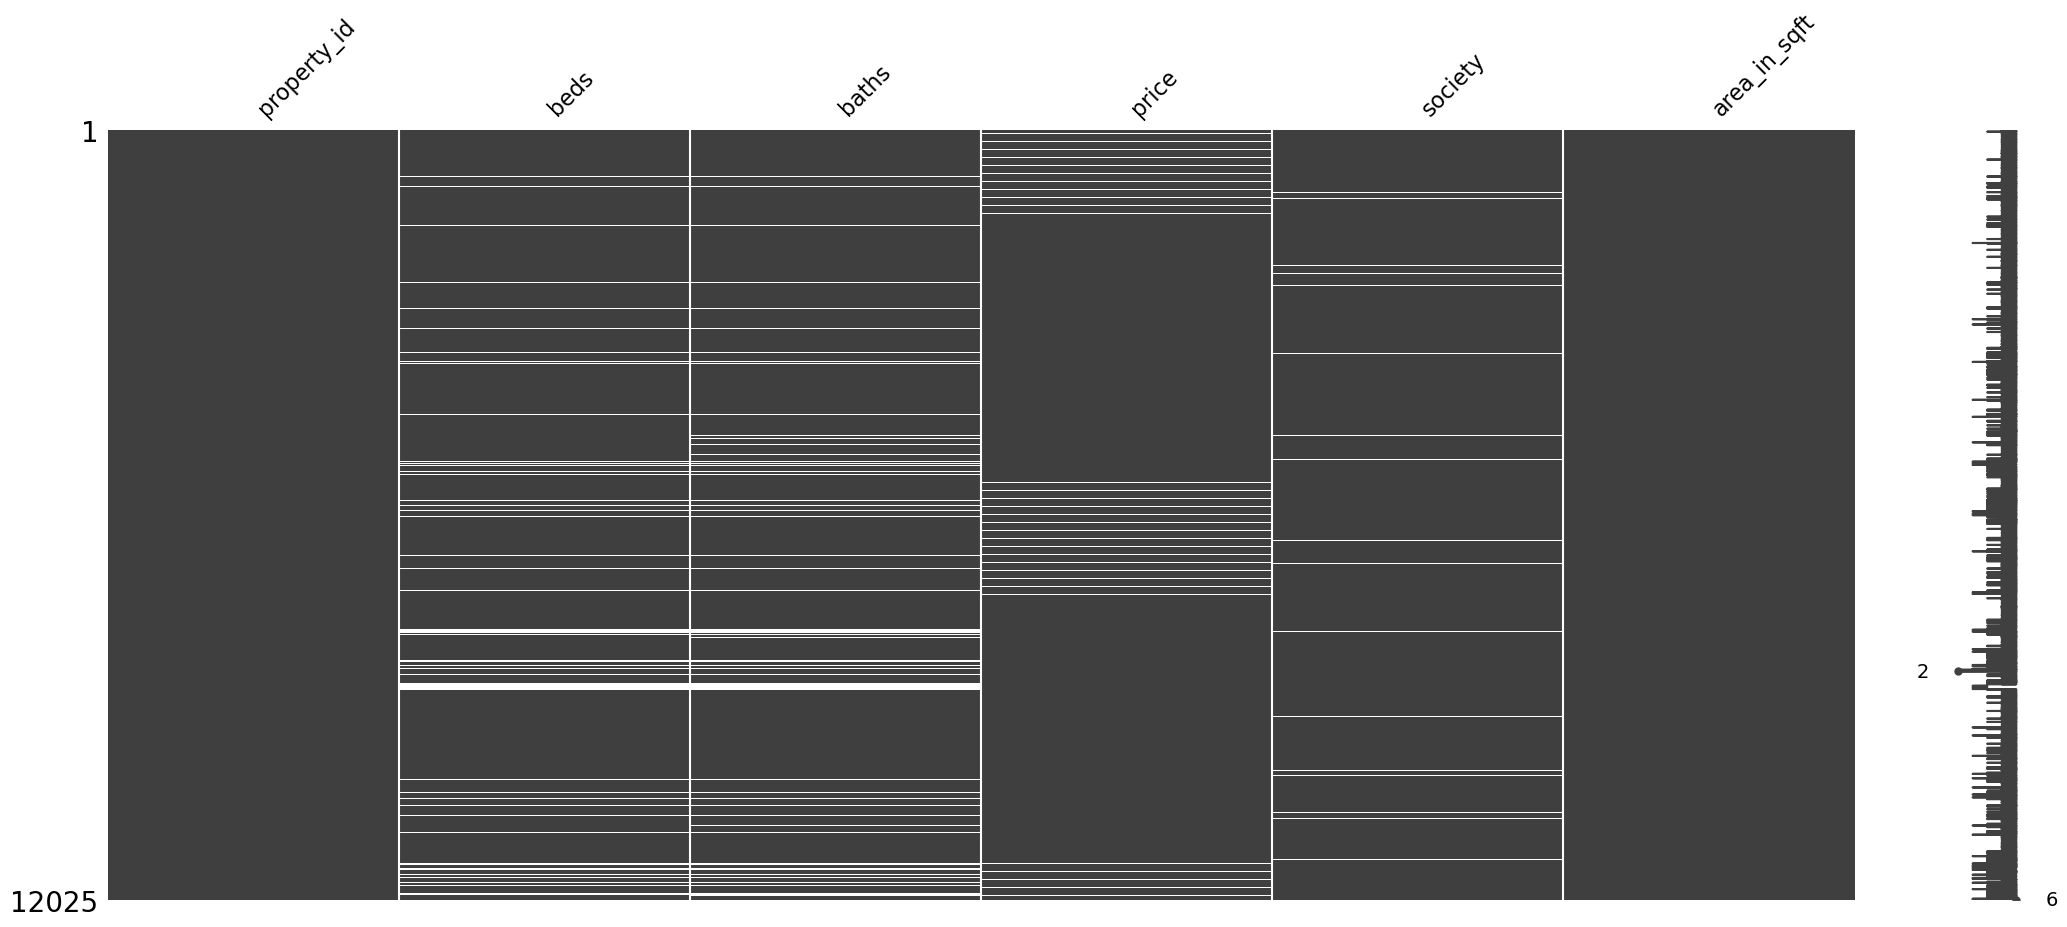

In [475]:
msno.matrix(df)

- First, we drop the rows with missing values in the target column. Filling these missing values could introduce bias into the model.
- In the society column, missing values cannot be filled reliably because we lack sufficient information about which houses belong to which society.

In [476]:
df.dropna(subset=['price', 'society'], inplace=True)

exluded date_added, remain features missing values are MCAR.
Now check the Distribution of these columns

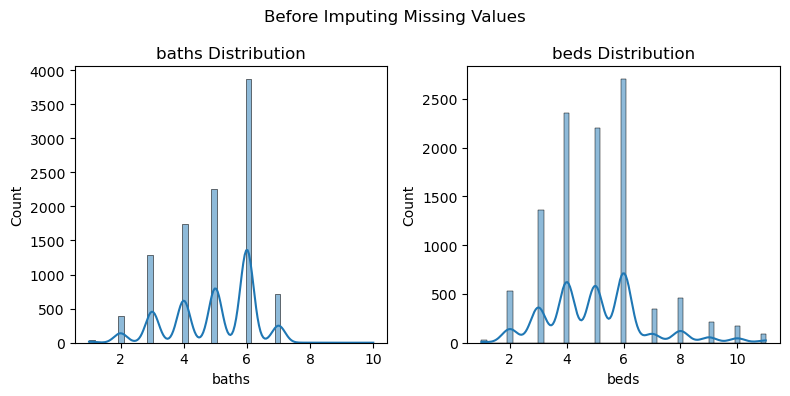

In [477]:
num_missing = ['baths','beds']

plt.figure(figsize=(8,4))
for i, col in enumerate(num_missing):
    plt.subplot(1,2,i+1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'{col} Distribution')
    plt.suptitle('Before Imputing Missing Values')
plt.tight_layout()
plt.show()


- As our baths feature values from 1 - 10, 
- Beds feature values from 1-11.

- In baths we use mode as the 6 apears more in the data so it can't effect on distribution 

In [478]:
df['baths'].fillna(df['baths'].mode()[0], inplace=True)

Approximately 6.6% of values are missing in the beds column. To preserve the original distribution, we fill missing values evenly with 4, 5, or 6

In [479]:
fill_values = [4, 5, 6]
missing_beds = df[df['beds'].isna()].index
df.loc[missing_beds, 'beds'] = np.random.choice(fill_values, size=len(missing_beds), replace=True)

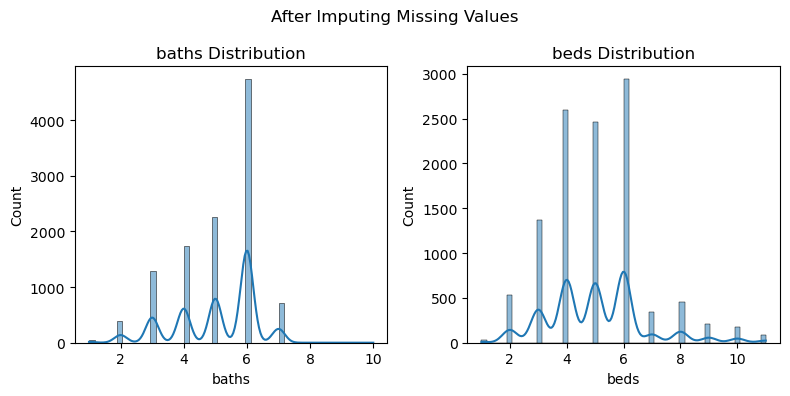

In [480]:
plt.figure(figsize=(8,4))
for i, col in enumerate(num_missing):
    plt.subplot(1,2,i+1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'{col} Distribution')
    plt.suptitle('After Imputing Missing Values')
plt.tight_layout()
plt.show()

In [481]:
change_type = ['beds', 'baths', 'price']
for i in change_type:
    df[i] = df[i].astype('int64')

--------

### Data Summary

In [482]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 11177 entries, 0 to 12024
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   property_id   11177 non-null  object 
 1   beds          11177 non-null  int64  
 2   baths         11177 non-null  int64  
 3   price         11177 non-null  int64  
 4   society       11177 non-null  object 
 5   area_in_sqft  11177 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 869.3+ KB


,beds,baths,price,area_in_sqft
count,11177.000000,11177.000000,1.117700e+04,11177.000000
mean,5.014852,5.044108,8.338548e+07,3142.147446
std,1.702180,1.293784,8.971227e+07,3118.576117
min,1.000000,1.000000,1.400000e+06,45.000000
25%,4.000000,4.000000,2.600000e+07,1125.000000
50%,5.000000,5.000000,5.600000e+07,2250.000000
75%,6.000000,6.000000,1.070000e+08,4500.000000
max,11.000000,10.000000,1.600000e+09,171000.000000


**Beds**
- The number of beds in the houses from 1 to 11.

**Baths**
- The number of bathrooms in the houses from 1 to 10.

**Date_added**
- The data is from 2024 - 2025

**Area_in_sqft**
- 45 - 171000, as these values are outliers, we will remove them as on website the max house are in sq ft is 18000

**Price**
- The min house price is 14 lac and max house price is 1.6 Arab

-----------

There are no duplicated Rows in the dataset

In [483]:
df.duplicated().sum()

0

----------

### Handle Outliers

Make a boxplot of numeric columns to check if there are any outliers.

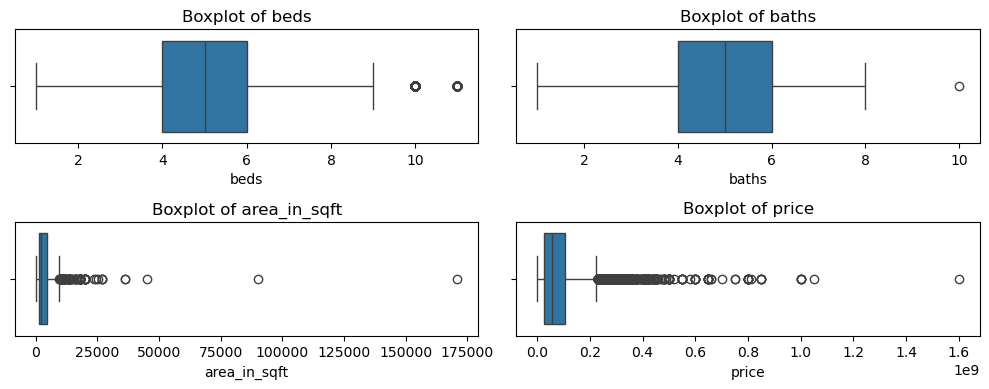

In [484]:
outlier = ['beds', 'baths','area_in_sqft', 'price']

plt.figure(figsize=(10, 4))
for i, col in enumerate(outlier):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


- Remove the baths column outlier as on website there are no more than 8 baths in a house
- Remove the area_in_sqft column outliers as on website there are no more than 36000 sqft in a house
- Remianing columns has a valid outlier so we didn't remove them.

In [485]:
df = df[df['baths'] < 8]

In [486]:
df= df[df['beds'] < 10]

In [487]:
df = df[df['area_in_sqft'] <= 36000]

In [488]:
df = df[df['price'] <= 800000000]

----------

## Exploratory Data Analysis

### Univarite Analysis

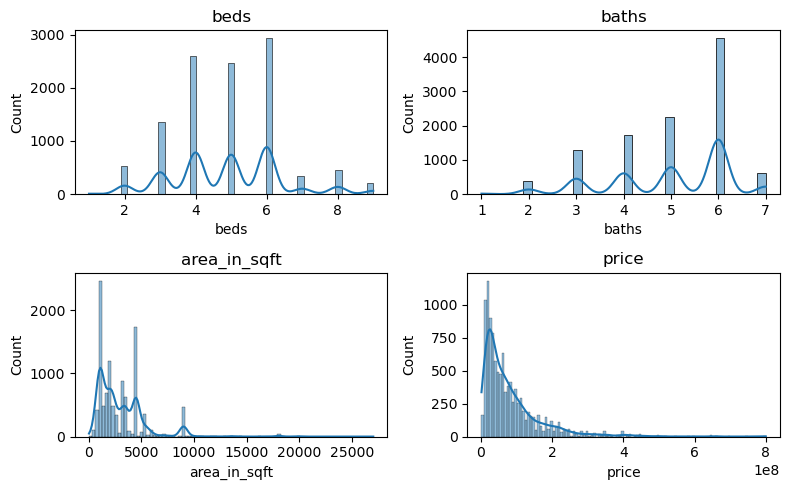

In [489]:
hist = ['beds', 'baths', 'area_in_sqft', 'price']

plt.figure(figsize=(8, 5))
for i, col in enumerate(hist):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x =df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

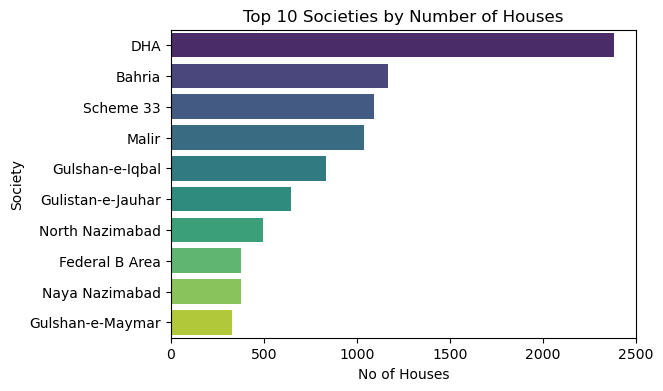

In [490]:
top_societies = df['society'].value_counts().head(10).reset_index()
top_societies.columns = ['society', 'count']

plt.figure(figsize=(6, 4))
sns.barplot(data=top_societies, y='society', x='count', palette='viridis')
plt.title('Top 10 Societies by Number of Houses')
plt.xlabel('No of Houses')
plt.ylabel('Society')
plt.show()

DHA societies have the highest number of listings compared to other societies 

---------

### Bivariate Analysis

**Beds vs Price**

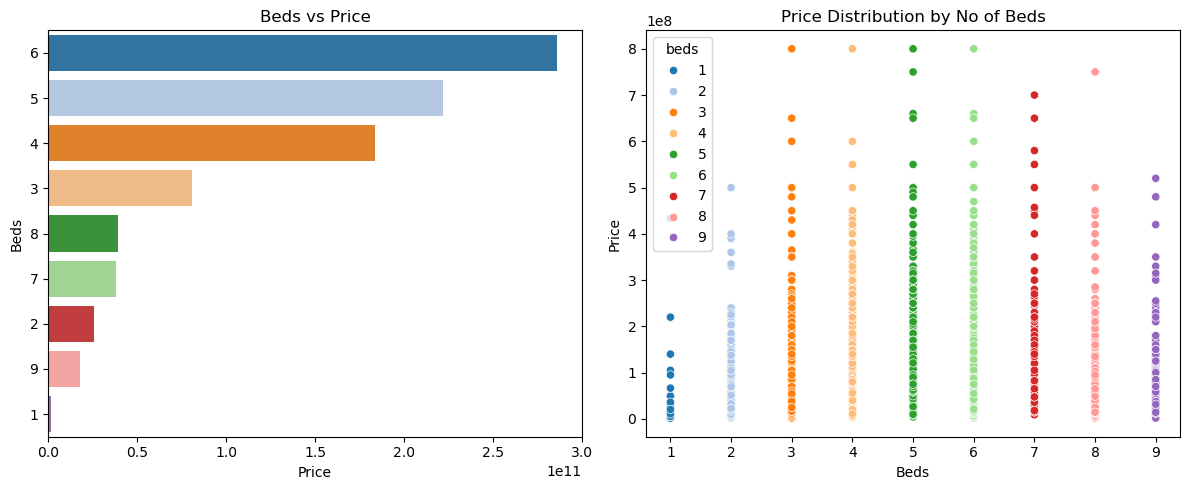

In [491]:
bed_price = df.groupby('beds')['price'].sum().sort_values(ascending=False).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=bed_price, y='beds', x='price', ax=axes[0], orient='h', 
            order=bed_price['beds'], palette='tab20')
axes[0].set_title('Beds vs Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Beds')

sns.scatterplot(data=df, x='beds', y='price', ax=axes[1], 
                hue='beds',palette='tab20')
axes[1].set_title('Price Distribution by No of Beds')
axes[1].set_ylabel('Price')
axes[1].set_xlabel('Beds')

plt.tight_layout()
plt.show()

- 4, 5, and 6-bed houses tend to have higher prices than others 
- We see a clear trend of price increase from 3 beds to 7 beds.

Baths vs Price

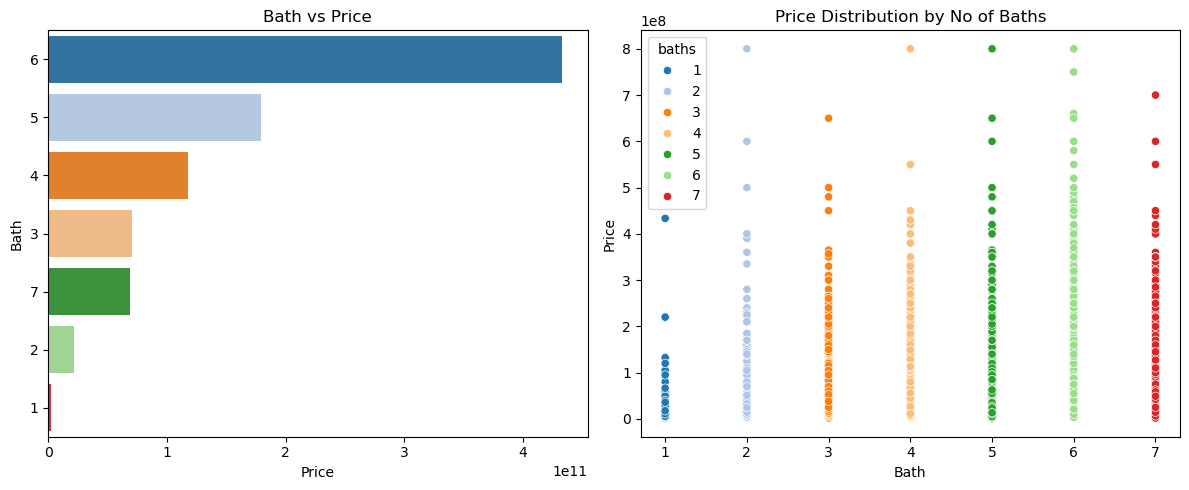

In [492]:
bath_price = df.groupby('baths')['price'].sum().sort_values(ascending=False).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=bath_price, y='baths', x='price', ax=axes[0], orient='h', 
            order=bath_price['baths'], palette='tab20')
axes[0].set_title('Bath vs Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Bath')

sns.scatterplot(data=df, x='baths', y='price', ax=axes[1], 
                hue='baths',palette='tab20')
axes[1].set_title('Price Distribution by No of Baths')
axes[1].set_ylabel('Price')
axes[1].set_xlabel('Bath')

plt.tight_layout()
plt.show()

- 4, 5, and 6-bath houses have higher prices than the others.
- There is a clear trend where as the number of baths increases, the house prices also tend to increase.

**Area Sq Ft vs Price**

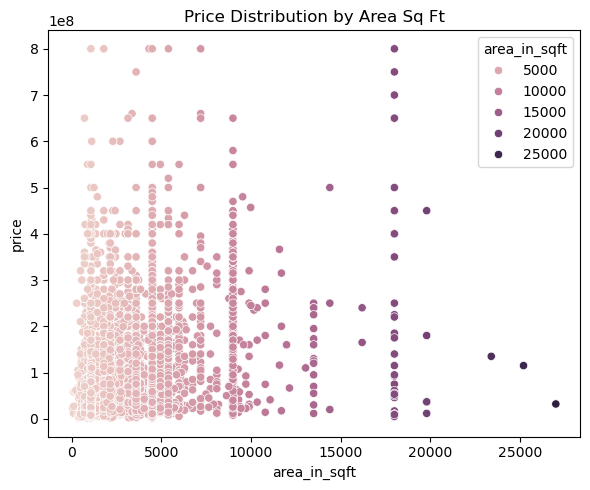

In [493]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x='area_in_sqft', y='price',hue='area_in_sqft')
plt.title('Price Distribution by Area Sq Ft')
plt.tight_layout()
plt.show()

- There are clusters of houses ranging from 500 sqft to 5000 sqft, and their prices vary. 
- Interestingly, some smaller houses are priced higher than larger ones, while in other cases, the larger houses are priced more.
- This suggests that price is not solely dependent on square footage.

**Society vs Price**

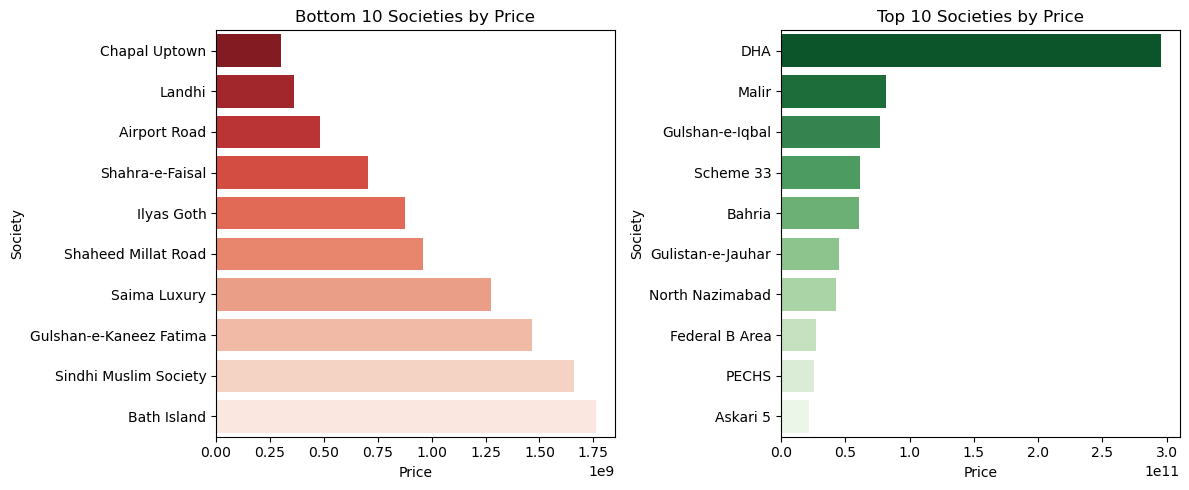

In [494]:
society_price = df.groupby('society')['price'].sum()

top10 = society_price.nlargest(10).sort_values(ascending=False)
bottom10 = society_price.nsmallest(10).sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=bottom10.values, y=bottom10.index, ax=axes[0], palette='Reds_r')
axes[0].set_title('Bottom 10 Societies by Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Society')

sns.barplot(x=top10.values, y=top10.index, ax=axes[1], palette='Greens_r')
axes[1].set_title('Top 10 Societies by Price')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Society')

plt.tight_layout()
plt.show()

- Chapal Uptown, Landhi, Airport Road, and Shahra-e-Faisal are well-known societies but have relatively lower average house prices. This may be due to fewer property listings in these areas, which can limit price variation and affect the average.
- On the other hand, DHA, Gulshan-e-Iqbal, Malir, Scheme 33, and Bahria are also popular societies but show higher average prices, likely because of a larger number of property listings, which increases market activity and raises the average

------------

### Multivariate Analysis

- Low price: less than 25th percentile < 25,800,000
- Medium price: between 25th and 75th percentile = 25,800,000 to 106,500,000
- High price: greater than 75th percentile > 106,500,000



In [495]:
bins = [0, 2.58e7, 1.065e8, float('inf')]
labels = ['Low', 'Medium', 'High']

df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels, include_lowest=True)

**Pairplot**

In [496]:
# sns.pairplot(df, hue='price_category')
# plt.show()

----

**Feature Engineering**

As we see that features are not powerful to predict the price of house, so we add some new features that help to predict the price of houses.

Price per square foot is a real estate metric that tells you how much you're paying for each square foot of property area.

In [497]:
df['price/sqft'] = df['price'] / df['area_in_sqft']

Avg price by society tells us that which society is more expensive and which is less expensive.

In [498]:
df['avgprice_bysociety'] = df.groupby('society')['price'].transform('mean')

In [499]:
df['area_per_bed'] = df['area_in_sqft'] / df['beds']

df['price_per_bed'] = (df['price/sqft'] * df['area_in_sqft']) / df['beds']


-----------

**Correlation Matrix**

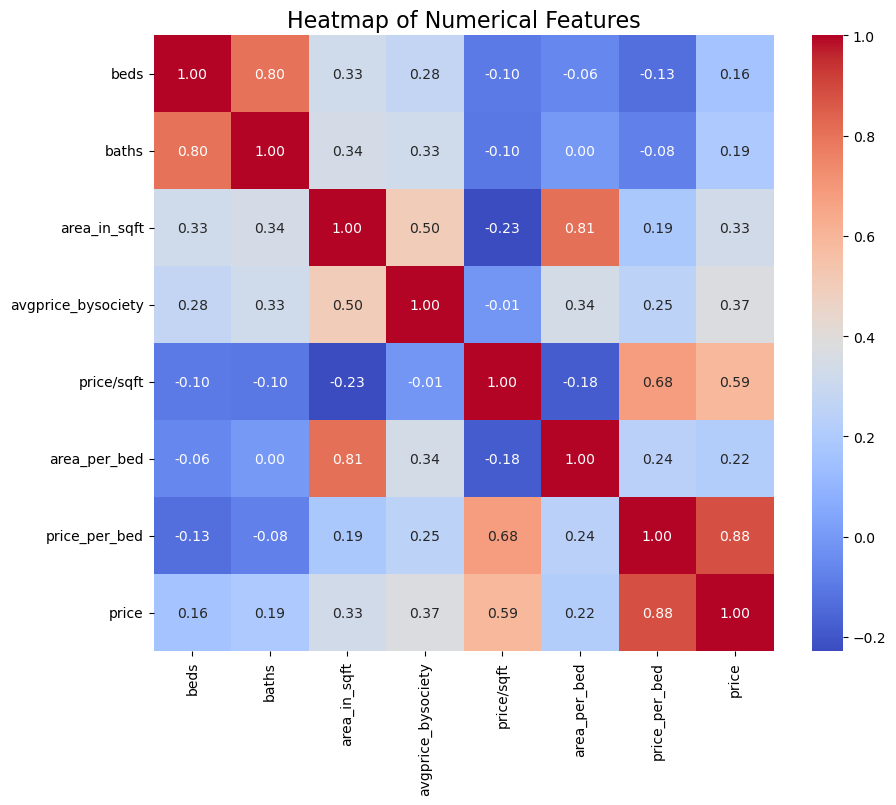

In [502]:
num = ['beds', 'baths', 'area_in_sqft','avgprice_bysociety','price/sqft','area_per_bed','price_per_bed','price']

plt.figure(figsize = (10, 8))
sns.heatmap(df[num].corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Heatmap of Numerical Features', fontsize = 16)

plt.show()

In [413]:
df.select_dtypes(include='number').corr()

,beds,baths,price,area_in_sqft,price/sqft,avgprice_bysociety,area_per_bed,price_per_bed
beds,1.000000,0.764979,0.156778,0.346471,-0.097502,0.268550,-0.059939,-0.143371
baths,0.764979,1.000000,0.187555,0.343147,-0.104386,0.326909,-0.000848,-0.085909
price,0.156778,0.187555,1.000000,0.328166,0.581019,0.373529,0.218451,0.874100
area_in_sqft,0.346471,0.343147,0.328166,1.000000,-0.226706,0.493881,0.786437,0.171436
price/sqft,-0.097502,-0.104386,0.581019,-0.226706,1.000000,-0.014500,-0.185019,0.678512
avgprice_bysociety,0.268550,0.326909,0.373529,0.493881,-0.014500,1.000000,0.343130,0.245184
area_per_bed,-0.059939,-0.000848,0.218451,0.786437,-0.185019,0.343130,1.000000,0.242549
price_per_bed,-0.143371,-0.085909,0.874100,0.171436,0.678512,0.245184,0.242549,1.000000


**Input Features correlation with Output**
- price/sqft are good correlated with price
- area_in_sqft and avgprice_bysociety are low correlated with price


**Input Features correlation with input features**
- beds are highly correlated with baths

----------

**Regplot**

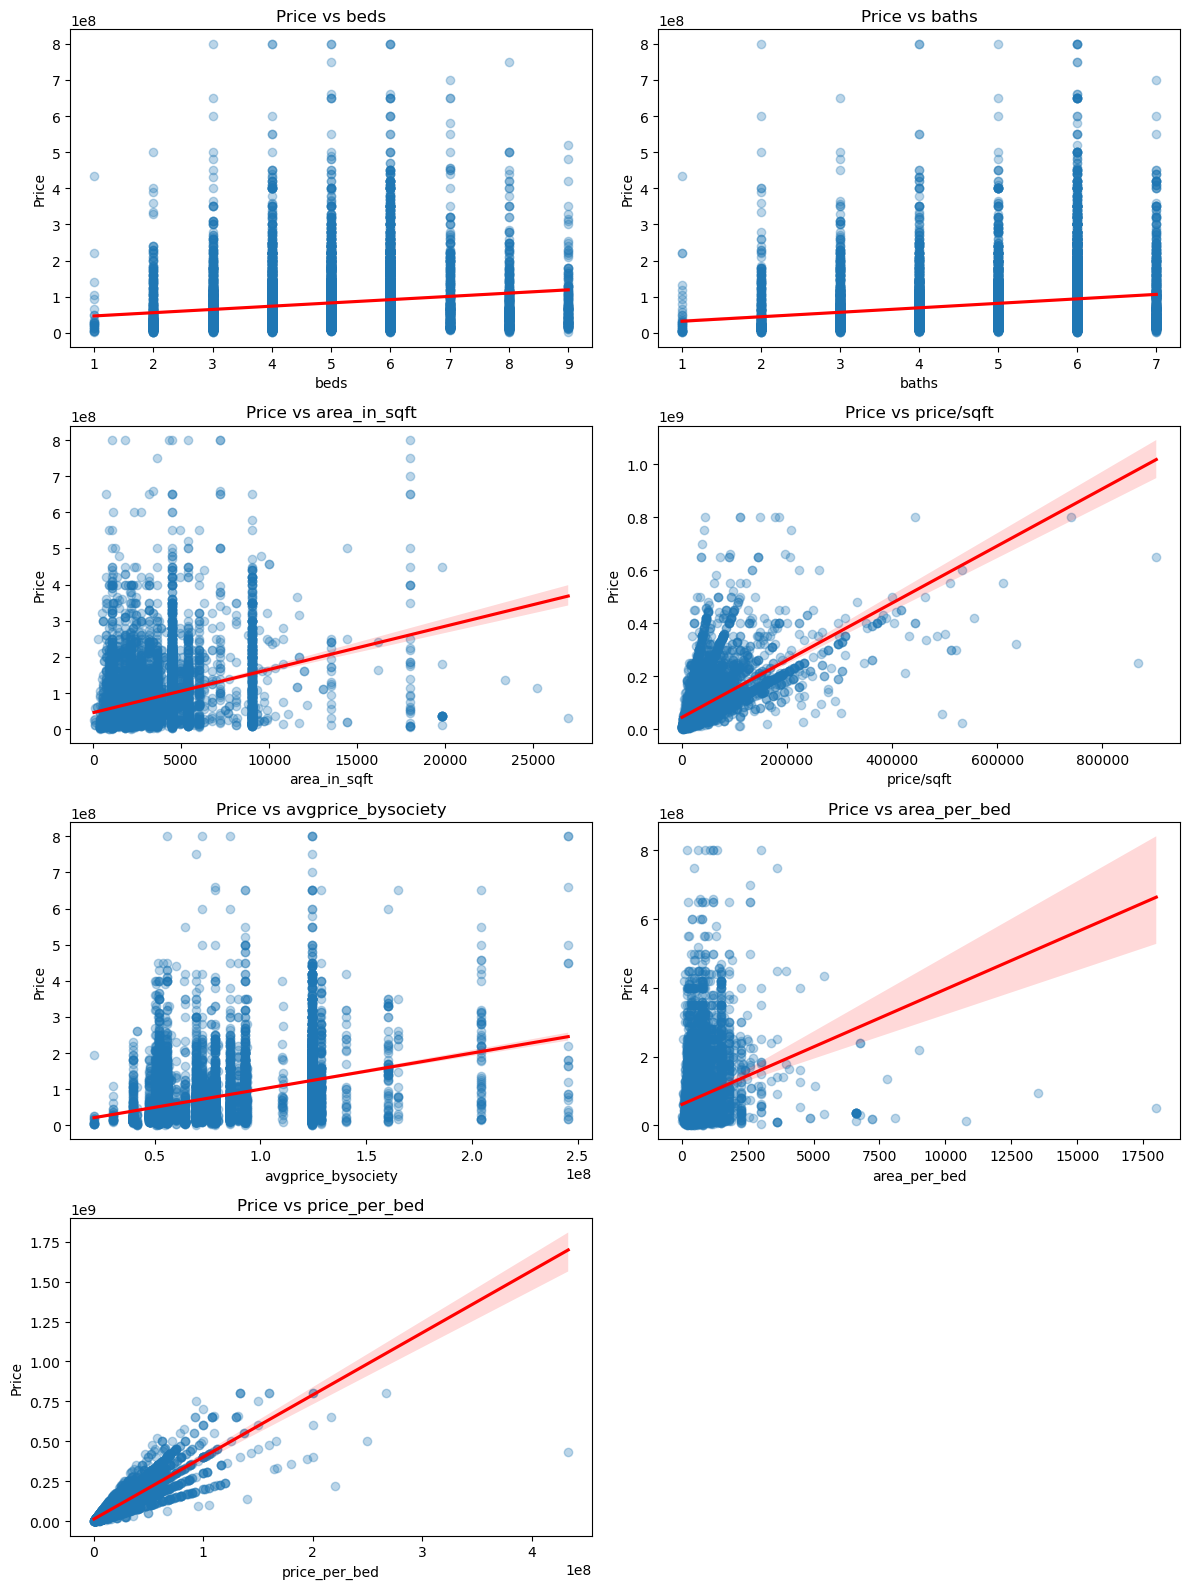

In [503]:
numeric_cols = df.select_dtypes(include='number').columns

numeric_cols = [col for col in numeric_cols if col != 'price']

n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.regplot(data=df, x=col, y='price', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title(f'Price vs {col}')
    plt.xlabel(col)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

----------------

Drop irrelevant features that didn't help in prediction.

In [505]:
df = df.drop(columns=['property_id', 'price_category'])

## Model Training

- We have a categorical column called society so firstly use one hot encoding on it.
- Remaining Numerical columns use Standard Scaler.

My plane is we make a pipeline of all these steps and then we can use it any where

In [541]:
df

,beds,baths,price,society,area_in_sqft,price/sqft,avgprice_bysociety,area_per_bed,price_per_bed
0,8,7,70000000,Scheme 33,3600.0,19444.444444,5.591062e+07,450.0,8.750000e+06
1,6,7,51500000,Scheme 33,2160.0,23842.592593,5.591062e+07,360.0,8.583333e+06
2,4,4,130000000,DHA,4500.0,28888.888889,1.241736e+08,1125.0,3.250000e+07
3,3,4,14500000,Bahria,1125.0,12888.888889,5.216879e+07,375.0,4.833333e+06
5,4,5,19200000,Scheme 33,1080.0,17777.777778,5.591062e+07,270.0,4.800000e+06
...,...,...,...,...,...,...,...,...,...
12020,2,2,70000000,KN Gohar Green,720.0,97222.222222,4.790789e+07,360.0,3.500000e+07
12021,4,4,10800000,Falcon Complex,4500.0,2400.000000,1.406483e+08,1125.0,2.700000e+06
12022,6,6,280000000,Gulshan-e-Iqbal,10800.0,25925.925926,9.278570e+07,1800.0,4.666667e+07
12023,5,6,450000000,PECHS,18000.0,25000.000000,1.285146e+08,3600.0,9.000000e+07


In [506]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [542]:
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['society']),
    ('num', StandardScaler(), ['area_in_sqft','price/sqft', 'avgprice_bysociety','area_per_bed','price_per_bed'])
], remainder='passthrough')


In [543]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [544]:
rfr = Pipeline([
        ('preprocessing', pre),
        ('regressor', RandomForestRegressor(random_state=23,n_jobs=-1, n_estimators=400, max_depth=40, min_samples_leaf=1))
    ])

In [545]:
rfr.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['society']),
                                                 ('num', StandardScaler(),
                                                  ['area_in_sqft', 'price/sqft',
                                                   'avgprice_bysociety',
                                                   'area_per_bed',
                                                   'price_per_bed'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=40, n_estimators=400,
                                       n_jobs=-1, random_state=23))])

Pred on both train and test data to check if the model is overfitting or not.

Find 
- MAE
- RMSE
- R2_Score
- Adjusted r2_score

**Model Evaluation**

In [546]:
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

n_train, k = X_train.shape
n_test = X_test.shape[0]

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
adj_r2_train = adjusted_r2(r2_train, n_train, k)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
adj_r2_test = adjusted_r2(r2_test, n_test, k)

In [547]:
print("Train Metrics:")
print(f"MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, R2: {r2_train:.3f}, Adjusted R2: {adj_r2_train:.3f}")

print("\nTest Metrics:")
print(f"MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R2: {r2_test:.3f}, Adjusted R2: {adj_r2_test:.3f}")

Train Metrics:
MAE: 228771.15, RMSE: 2600581.69, R2: 0.999, Adjusted R2: 0.999

Test Metrics:
MAE: 365820.53, RMSE: 2771051.89, R2: 0.999, Adjusted R2: 0.999


----------

These results are before and after doing CV and Grid Search

**Random Forest Regressor - Before hyperparameter tuning**
- Train Set:
  - MAE: 510352.44
  - RMSE: 4583525.25
  - R²: 0.99
  - Adjusted R²: 0.99

#######################################################

- Test Set:
  - MAE: 1377294.05
  - RMSE: 7038842.70
  - R²: 0.997
  - Adjusted R²: 0.997

**Random Forest Regressor - After hyperparameter tuning**
- Train Set:
  - MAE: 459277.07
  - RMSE: 3289846.74
  - R²: 0.998
  - Adjusted R²: 0.998
  
#######################################################

- Test Set:
  - MAE: 1048593.05
  - RMSE: 4917267.70
  - R²: 0.997
  - Adjusted R²: 0.997

--------

**DTR**
- The model underfits the data.
- It fails to capture underlying patterns due to being too simple or overly constrained.
 
**LR**
- Not underfitting
- But the score is low
- The Error is to high
- Feature correlations are weak, so the model can't effectively explain the variance.

**RFR**
- MAE reduced from 1377294 to 1048593
- RMSE reduced from 7038842 to 4917267
- R2 score remain same
- RFR is an ensemble model that aggregates multiple trees, which helps capture non-linear relationships and feature interactions.

--------

Lets create a func that tell us the prices of houses

In [550]:
def houses_price_prediction(rfr_pipeline, df, beds, baths, area_in_sqft, society):
    # Compute the price per sqft and average price per society
    price_per_sqft = df['price'].sum() / df['area_in_sqft'].sum()
    avg_price_soc = df[df['society'] == society]['price'].sum() / df[df['society'] == society]['area_in_sqft'].sum()

    # Calculate the missing features
    area_per_bed = area_in_sqft / beds if beds != 0 else 0
    area_per_bath = area_in_sqft / baths if baths != 0 else 0
    price_per_bed = price_per_sqft * area_per_bed
    price_per_bath = price_per_sqft * area_per_bath

    # Create a DataFrame for the input features
    data = pd.DataFrame([{
        'beds': beds,
        'baths': baths,
        'area_in_sqft': area_in_sqft,
        'price/sqft': price_per_sqft,
        'avgprice_bysociety': avg_price_soc,
        'society': society,
        'area_per_bed': area_per_bed,
        'area_per_bath': area_per_bath,
        'price_per_bed': price_per_bed,
        'price_per_bath': price_per_bath
    }])

    # Make the prediction
    predicted_price = rfr_pipeline.predict(data)[0]
    print(f"The House Price of the '{society}' is {predicted_price / 100000:.2f} Lakhs")


Predict the Houses price of different locations in Karachi

We are taking 5,5 beds and baths and 1800 sqft area of different societies to check how well model were performing

In [551]:
houses_price_prediction(rfr, df, beds=5, baths=5, area_in_sqft=2000, society='Scheme 33')
houses_price_prediction(rfr, df, beds=5, baths=5, area_in_sqft=2000, society='DHA')
houses_price_prediction(rfr, df, beds=5, baths=5, area_in_sqft=2000, society='Gulistan-e-Jauhar')
houses_price_prediction(rfr, df, beds=5, baths=5, area_in_sqft=2000, society='Malir')
houses_price_prediction(rfr, df, beds=5, baths=5, area_in_sqft=2000, society='North Nazimabad')
houses_price_prediction(rfr, df, beds=5, baths=5, area_in_sqft=2000, society='Saadi Town')

The House Price of the 'Scheme 33' is 540.15 Lakhs
The House Price of the 'DHA' is 540.15 Lakhs
The House Price of the 'Gulistan-e-Jauhar' is 540.16 Lakhs
The House Price of the 'Malir' is 540.19 Lakhs
The House Price of the 'North Nazimabad' is 540.15 Lakhs
The House Price of the 'Saadi Town' is 540.15 Lakhs


In [515]:
rfr.fit(X_train, y_train)
feature_importances = rfr.named_steps['regressor'].feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")


Feature: beds, Importance: 1.849344623593838e-08
Feature: baths, Importance: 9.81692565602855e-08
Feature: society, Importance: 2.478500711773851e-08
Feature: area_in_sqft, Importance: 0.00012105830276345084
Feature: price/sqft, Importance: 1.9522838685295167e-07
Feature: avgprice_bysociety, Importance: 1.0741849333814309e-07
Feature: area_per_bed, Importance: 5.107877307325103e-09
Feature: price_per_bed, Importance: 3.4449872186006234e-07


In [516]:
from sklearn.linear_model import LinearRegression

In [517]:
features = ['beds', 'baths', 'area_in_sqft', 'price/sqft', 'avgprice_bysociety', 
            'area_per_bed', 'price_per_bed']

# Target variable
target = 'price'

# Prepare X and y
X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Evaluation metrics function
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    k = X.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

    print(f"\n{dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.3f}")
    print(f"Adjusted R2: {adj_r2:.3f}")

# Evaluate on training and test sets
evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_test, y_test_pred, "Test")


Train Metrics:
MAE: 15955906.71
RMSE: 30413933.74
R2: 0.870
Adjusted R2: 0.870

Test Metrics:
MAE: 16364431.29
RMSE: 28151164.81
R2: 0.891
Adjusted R2: 0.891


In [522]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming you already have X_train, X_test, y_train, y_test

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    adj_r2_train = 1 - (1 - r2_train) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)

    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    adj_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    print(f"\n📌 {model_name} Regression Results")
    print(f"Train -> MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, R2: {r2_train:.3f}, Adj R2: {adj_r2_train:.3f}")
    print(f"Test  -> MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R2: {r2_test:.3f}, Adj R2: {adj_r2_test:.3f}")
    return model

# Try Ridge Regression
ridge_model = Ridge(alpha=0.001)
evaluate_model(ridge_model, X_train, X_test, y_train, y_test, "Ridge")

# Try Lasso Regression
lasso_model = Lasso(alpha=0.001)
evaluate_model(lasso_model, X_train, X_test, y_train, y_test, "Lasso")


📌 Ridge Regression Results
Train -> MAE: 15955906.61, RMSE: 30413933.74, R2: 0.870, Adj R2: 0.870
Test  -> MAE: 16364431.21, RMSE: 28151164.86, R2: 0.891, Adj R2: 0.891

📌 Lasso Regression Results
Train -> MAE: 15955906.70, RMSE: 30413933.74, R2: 0.870, Adj R2: 0.870
Test  -> MAE: 16364431.28, RMSE: 28151164.81, R2: 0.891, Adj R2: 0.891


Lasso(alpha=0.001)

In [539]:
def houses_price_prediction(model, df, beds, baths, area_in_sqft, society):
    # Get average price/sqft by society (or set a fallback if not found)
    avg_price_per_sqft = df[df['society'] == society]['price/sqft'].mean()
    avgprice_bysociety = df[df['society'] == society]['price'].mean()

    # Fallback if society not found
    if pd.isna(avg_price_per_sqft):
        avg_price_per_sqft = df['price/sqft'].mean()
    if pd.isna(avgprice_bysociety):
        avgprice_bysociety = df['price'].mean()

    # Derived features
    area_per_bed = area_in_sqft / beds
    price_per_bed = (avg_price_per_sqft * area_in_sqft) / beds

    # Create input DataFrame (include only features used during training)
    input_data = pd.DataFrame([{
        'beds': beds,
        'baths': baths,
        'area_in_sqft': area_in_sqft,
        'price/sqft': avg_price_per_sqft,
        'avgprice_bysociety': avgprice_bysociety,
        'area_per_bed': area_per_bed,
        'price_per_bed': price_per_bed
    }])

    # Predict
    predicted_price = model.predict(input_data)[0]
    print(f"Predicted Price for '{beds} Bed' / '{baths} Bath' in '{society}' of '{area_in_sqft} sqft' house = {predicted_price:,.0f} PKR")


In [540]:
houses_price_prediction(lr, df, beds=5, baths=5, area_in_sqft=2000, society='Scheme 33')
houses_price_prediction(lr, df, beds=5, baths=5, area_in_sqft=2000, society='DHA')
houses_price_prediction(lr, df, beds=5, baths=5, area_in_sqft=2000, society='Saadi Town')
houses_price_prediction(lr, df, beds=5, baths=5, area_in_sqft=2000, society='Gulistan-e-Jauhar')
houses_price_prediction(lr, df, beds=5, baths=5, area_in_sqft=2000, society='Malir')


Predicted Price for '5 Bed' / '5 Bath' in 'Scheme 33' of '2000 sqft' house = 74,137,149 PKR
Predicted Price for '5 Bed' / '5 Bath' in 'DHA' of '2000 sqft' house = 68,893,352 PKR
Predicted Price for '5 Bed' / '5 Bath' in 'Saadi Town' of '2000 sqft' house = 61,765,435 PKR
Predicted Price for '5 Bed' / '5 Bath' in 'Gulistan-e-Jauhar' of '2000 sqft' house = 75,815,293 PKR
Predicted Price for '5 Bed' / '5 Bath' in 'Malir' of '2000 sqft' house = 56,312,819 PKR
